# Setup and useful functions

In [3]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from matplotlib import pyplot as plt
from skimage.transform import resize
from sklearn import manifold
import numpy as np
import glob
import cv2

from sklearn.manifold import MDS
import seaborn as sns
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [4]:
filelist = glob.glob(r'C:\Users\Gustavo Scholze\gan-for-mps\data\temp\wgan\*.png')
x = []
for fname in filelist:
    im = cv2.imread(fname, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Binarization
    ret, th = cv2.threshold(blurred,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    x.append(th)

x = np.array(x)

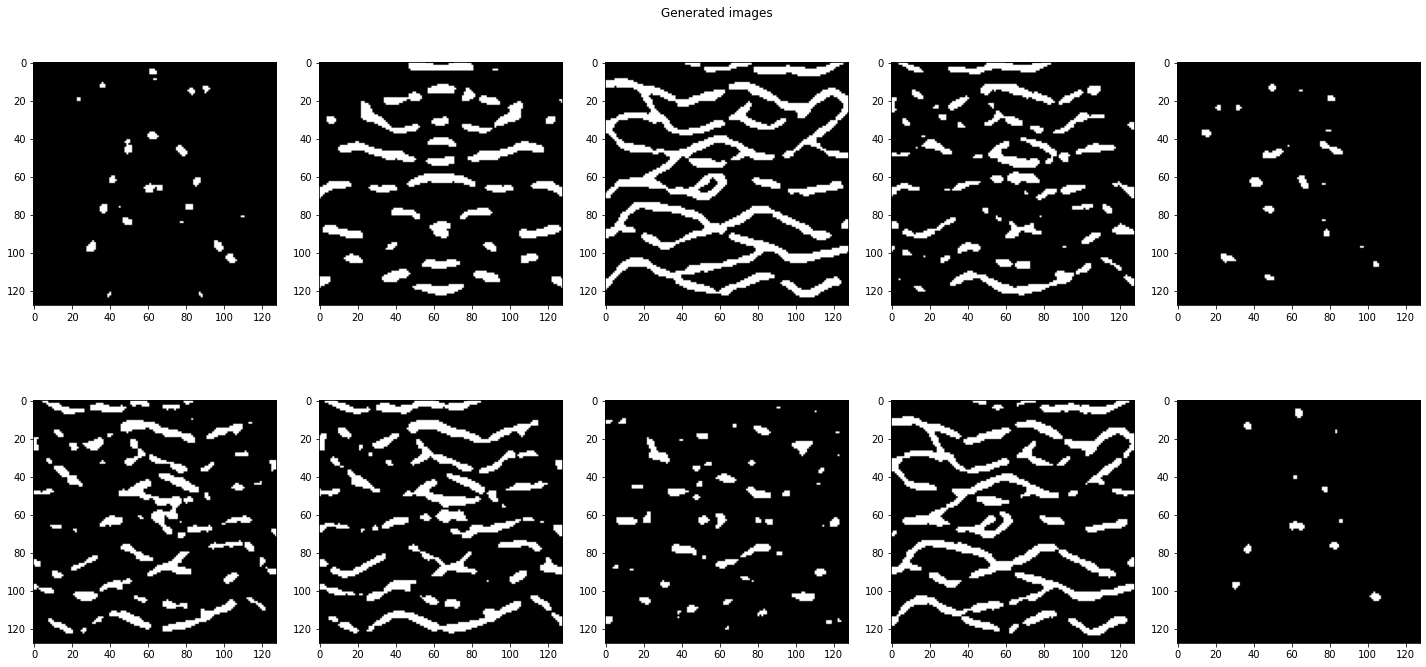

In [5]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=False, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.
    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    plt.suptitle("Generated images")
    _ = plt.show()


show_image_list(x[30:40], list_cmaps=['gray']*10, num_cols=5)

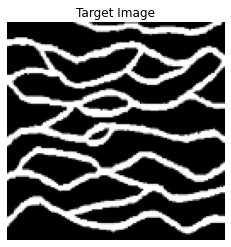

In [6]:
im = cv2.imread(r'C:\Users\Gustavo Scholze\gan-for-mps\data\TI\strebelle.png', cv2.COLOR_BGR2GRAY)

# Binarization
ret, target_img = cv2.threshold(im,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Resize image
target_img = resize(target_img, (128,128))

plt.imshow(target_img, cmap='gray')
plt.title('Target Image')
plt.axis('off')
plt.show()

# Structural similarity and Mean squared error

In [7]:
mse_none = [mean_squared_error(im, target_img) for im in x]
ssim_none = [ssim(im, target_img, data_range=im.max()-im.min()) for im in x]

c:\Users\Gustavo Scholze\gan-for-mps\.venv\lib\site-packages\skimage\metrics\_structural_similarity.py:230: RuntimeWarning: invalid value encountered in true_divide
  S = (A1 * A2) / D


In [8]:
similar = ssim_none.copy()
similar.sort(reverse=True)

# Get indexes from best and worst simulations to see if it matches
worst_10_images_ssim = similar[:10]
worst_10_idxs_ssim = [ssim_none.index(similarity_coef) for similarity_coef in worst_10_images_ssim]

best_10_images_ssim = similar[len(similar)-10:len(similar)]
best_10_idxs_ssim = [ssim_none.index(similarity_coef) for similarity_coef in best_10_images_ssim]


similar_mse = mse_none.copy()
similar_mse.sort(reverse=True)

# Get indexes from best and worst simulations to see if it matches
best_10_images_mse = similar_mse[:10]
best_10_idxs_mse = [mse_none.index(similarity_coef) for similarity_coef in best_10_images_mse]

worst_10_images_mse = similar_mse[len(similar_mse)-10:len(similar_mse)]
worst_10_idxs_mse = [mse_none.index(similarity_coef) for similarity_coef in worst_10_images_mse]

### Structural similarity

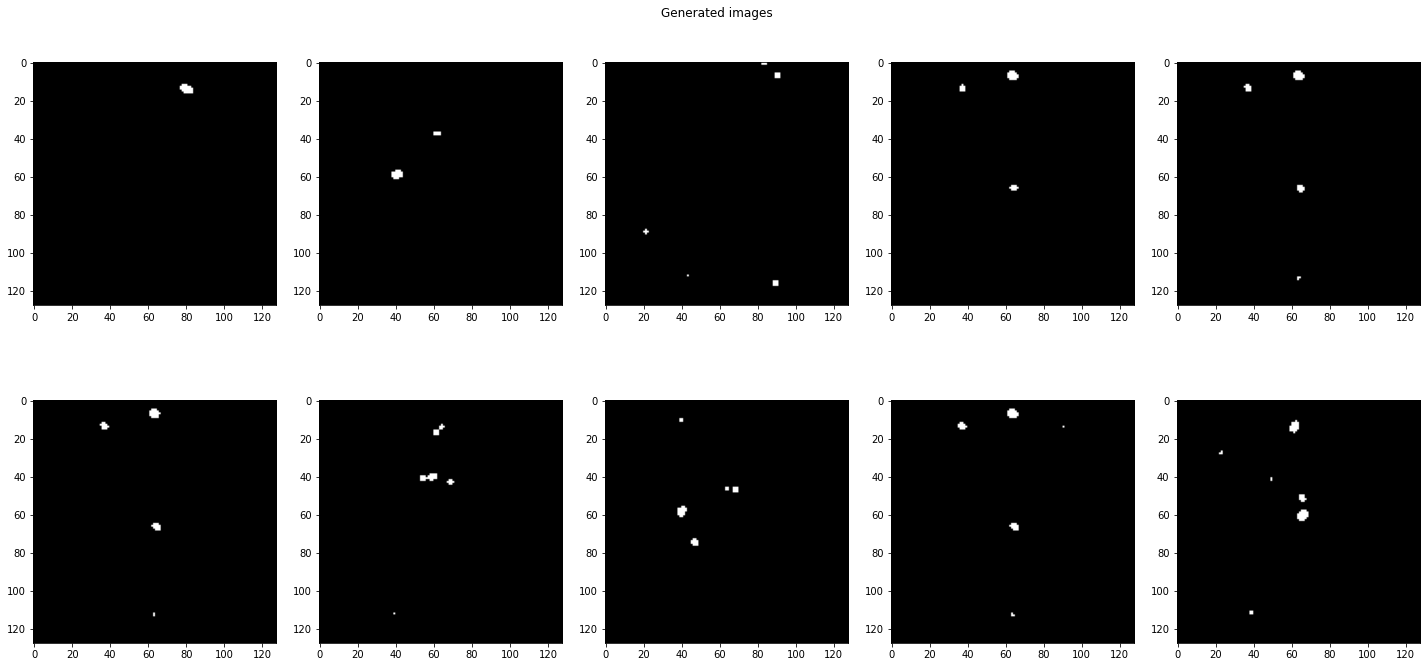

In [9]:
# Worst images by structural similarity
show_image_list(x[worst_10_idxs_ssim], list_cmaps=['gray']*10, num_cols=5)

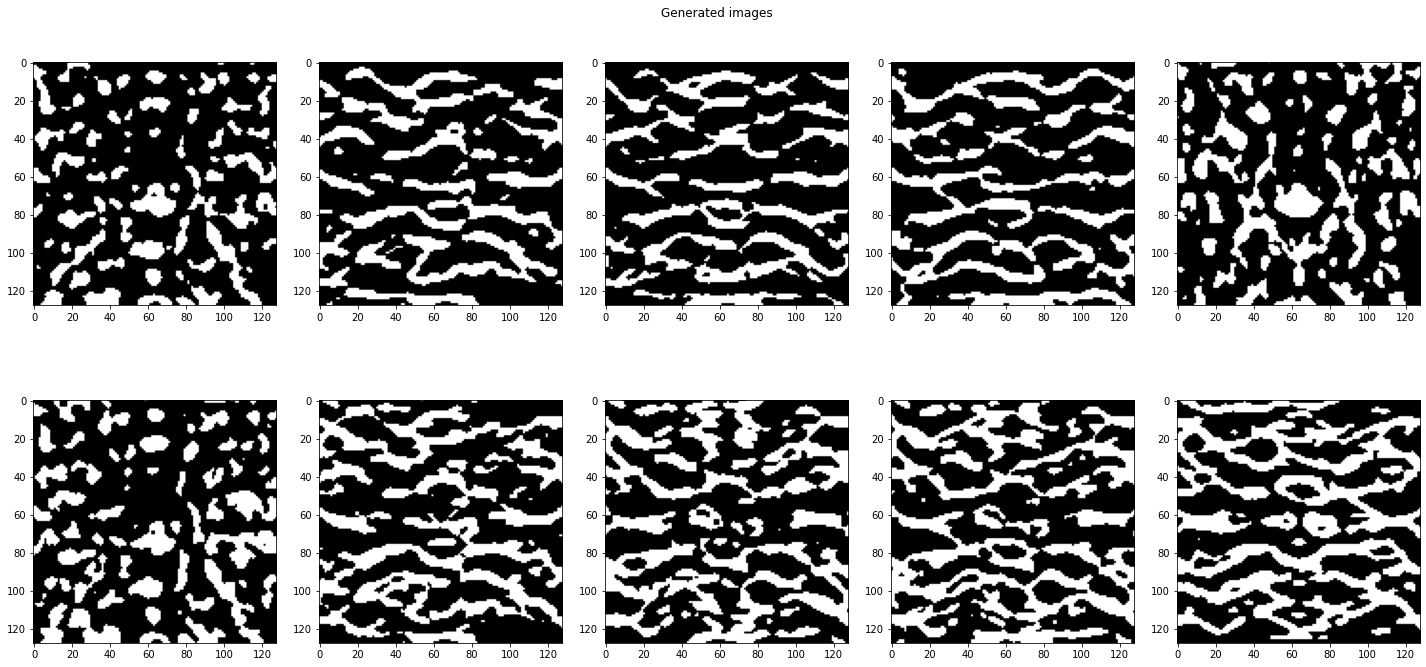

In [10]:
# Best images by structural similarity
show_image_list(x[best_10_idxs_ssim], list_cmaps=['gray']*10, num_cols=5)

### Mean squared error

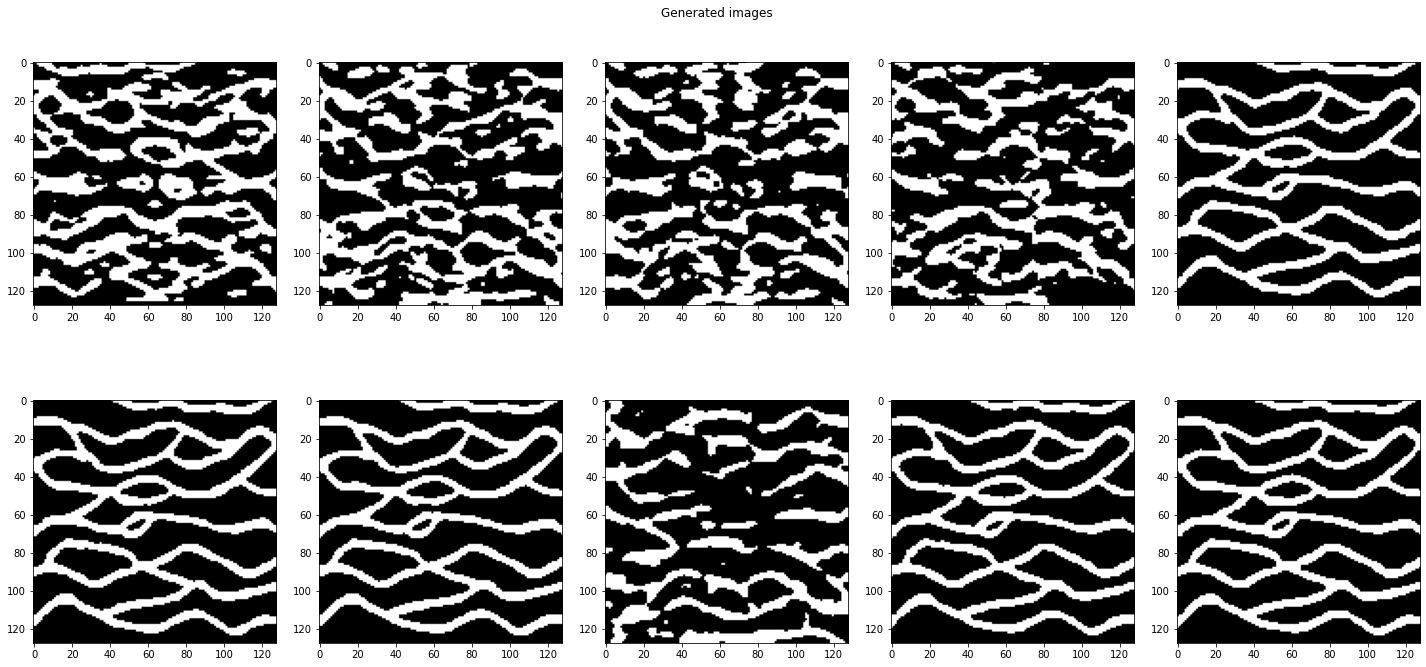

In [11]:
# Worst images using MSE
show_image_list(x[best_10_idxs_mse], list_cmaps=['gray']*10, num_cols=5)

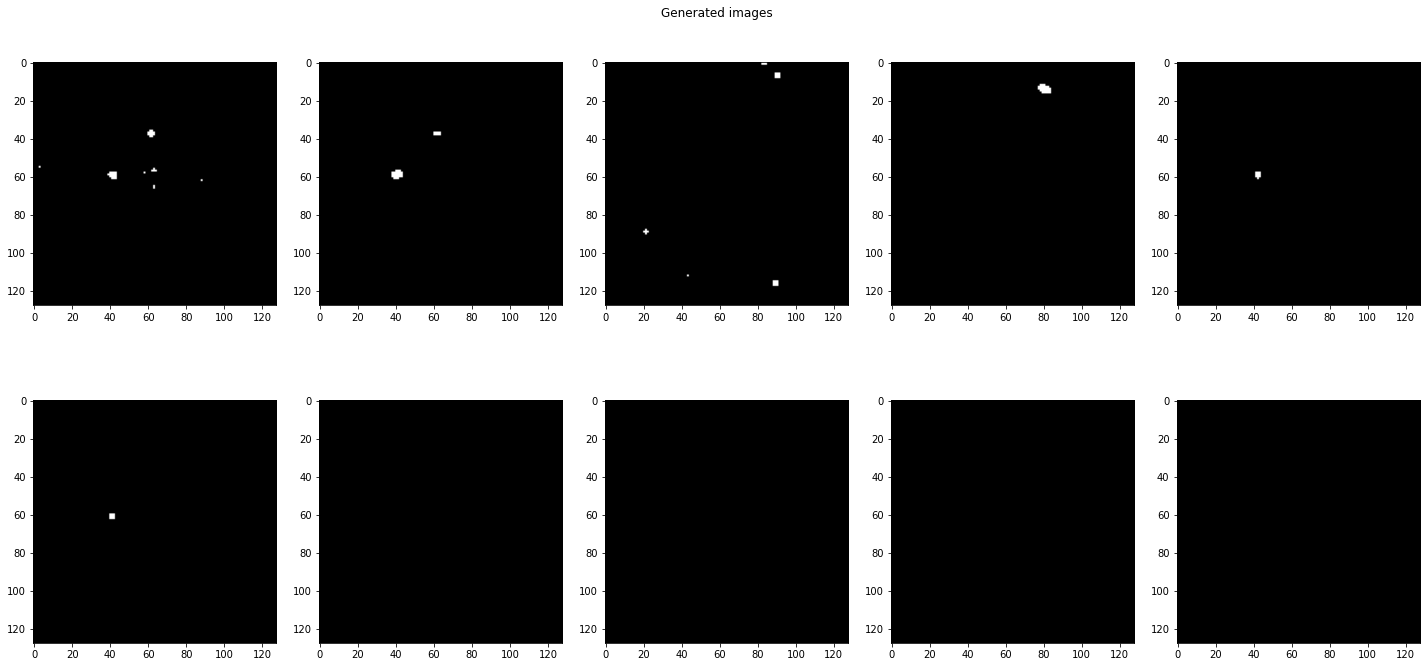

In [12]:
show_image_list(x[worst_10_idxs_mse], list_cmaps=['gray']*10, num_cols=5)

### Comparison with grid

In [13]:
import cv2
import itertools

class CompareTrainingImage(object):

    def __init__(self, image_1_path, image_2_path):
        self.minimum_commutative_image_diff = 1
        self.image_1_path = image_1_path
        self.image_2_path = image_2_path

    def compare_image(self):
        image_1 = cv2.imread(self.image_1_path, 0)
        image_2 = cv2.imread(self.image_2_path, 0)
        commutative_image_diff = self.get_image_difference(image_1, image_2)
        
        if commutative_image_diff < self.minimum_commutative_image_diff:
            return commutative_image_diff
        return None

    @staticmethod
    def get_image_difference(image_1, image_2):
        first_image_hist = cv2.calcHist([image_1], [0], None, [256], [0, 256])
        second_image_hist = cv2.calcHist([image_2], [0], None, [256], [0, 256])

        img_hist_diff = cv2.compareHist(first_image_hist, second_image_hist, cv2.HISTCMP_BHATTACHARYYA)
        img_template_probability_match = cv2.matchTemplate(first_image_hist, second_image_hist, cv2.TM_CCOEFF_NORMED)[0][0]
        img_template_diff = 1 - img_template_probability_match

        # taking only 10% of histogram diff, since it's less accurate than template method
        commutative_image_diff = (img_hist_diff / 10) + img_template_diff
        return commutative_image_diff

counter=[]
for im_path in os.listdir("C:/Users/Gustavo Scholze/gan-for-mps/data/temp/wgan"):
    compare_image = CompareTrainingImage(im_path, "data/TI/strebelle.png")
    image_difference = compare_image.compare_image()
    if image_difference!=None:
        counter.append(image_difference)

eas: file ->../data/conditioning_data/samples50
eas: title->           samples50


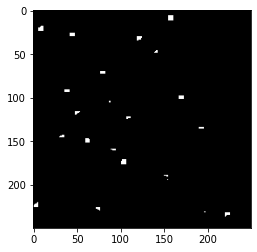

In [14]:
from helpers.funcs import *
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Create the grid with loaded conditioning data
conditioning_dictionary = read_conditional_samples("../data/conditioning_data/samples50")
conditioning = conditioning_dictionary['D']
conditioning = convert_to_grid(conditioning)

conditional_mask = Image.fromarray(conditioning.astype(np.uint8)).resize((250,250), Image.NEAREST)

image = Image.open(r"C:\Users\Gustavo Scholze\gan-for-mps\data\TI\strebelle.png")
# read mask as grayscale in range 0 to 255
result = (np.asarray(image) * np.asarray(conditional_mask)).clip(0, 1).astype(np.uint8)
plt.imshow(result, cmap='gray')

## Post-processing simulated images

In [18]:
import glob
import cv2
import numpy as np

filelist = glob.glob(r'C:\Users\Gustavo Scholze\data\temp\wgan\wgan128\*.png')
x_simulated = []
for fname in filelist:
    im = cv2.imread(fname, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Binarization
    ret, th = cv2.threshold(blurred,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Image resizing
    width = 128
    height = 128
    dim = (width, height)
    
    # resize image
    resized = cv2.resize(th, dim, interpolation = cv2.INTER_AREA)

    x_simulated.append(resized)

x_simulated = np.array(x_simulated)

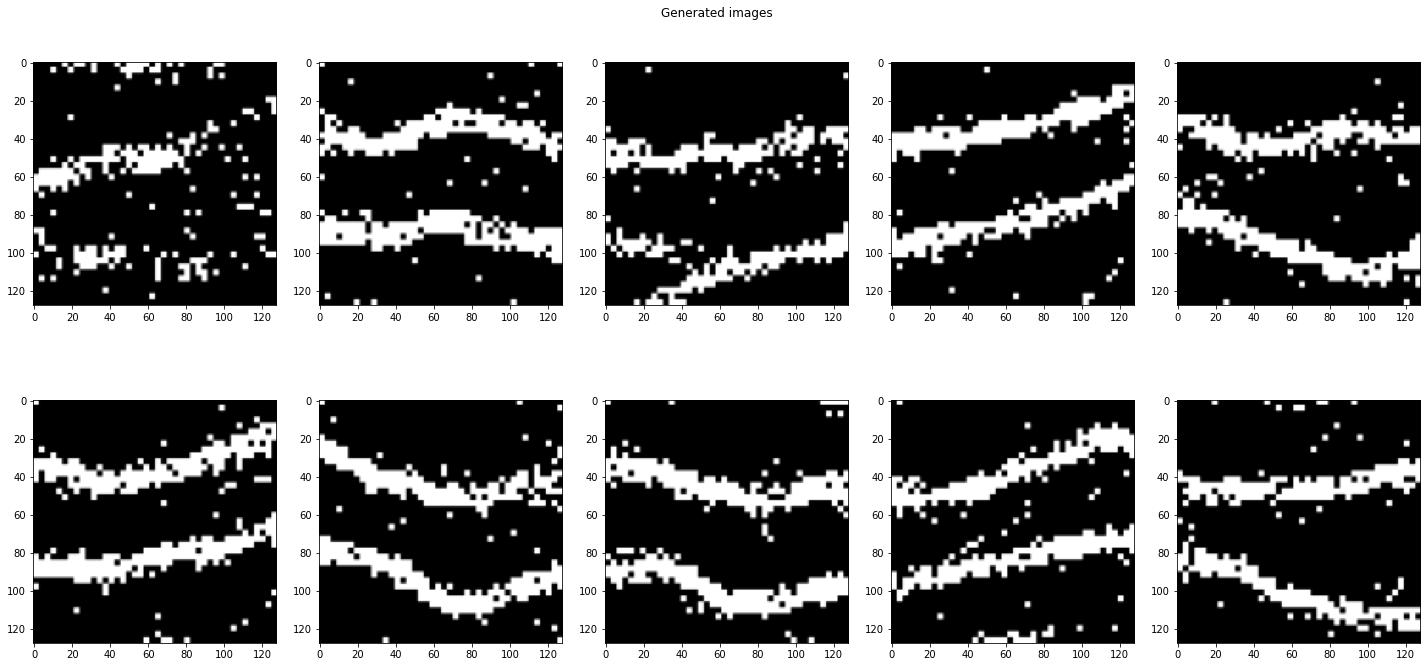

In [19]:
show_image_list(x_simulated[30:40], list_cmaps=['gray']*10, num_cols=5)

# Multidimensional scaling

In [20]:
from PIL import Image

filelist = glob.glob(r'C:\Users\Gustavo Scholze\data\temp\wgan\wgan128\*.png')

# Looping through images and converting them
x = []
for fname in filelist:
    im = cv2.imread(fname, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Binarization
    ret, th = cv2.threshold(blurred,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    x.append(th.flatten())

In [21]:
from PIL import Image

filelist_augmented = glob.glob(r'C:\Users\Gustavo Scholze\gan-for-mps\data\temp\augmented\exp\*.png')

# Looping through images and converting them
x_augmented = []
for fname in filelist_augmented:
    im = cv2.imread(fname, cv2.COLOR_BGR2GRAY)
    x_augmented.append(th.flatten())

In [23]:
mds = manifold.MDS(n_components=2, max_iter=100000, random_state=0)
coords = mds.fit(x).embedding_
coords_augmented = mds.fit(x_augmented).embedding_

print("Stress coefficient: ", mds.stress_)
print("Number of iterations: ", mds.n_iter_)

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], marker='x', color="black", s=50)
plt.scatter(coords_augmented[:, 0], coords_augmented[:, 1], marker='x', color="blue", s=50)